In [9]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [10]:
df = pd.read_csv("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/train.csv")
df.head()

# Dimensions of the data
print(df.shape)

(148060, 3)


In [11]:
train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="timestamp"
)
train_data.head()

target
item_id timestamp                  
H1      1750-01-01 00:00:00   605.0
        1750-01-01 01:00:00   586.0
        1750-01-01 02:00:00   586.0
        1750-01-01 03:00:00   559.0
        1750-01-01 04:00:00   511.0

In [12]:
predictor = TimeSeriesPredictor(
    prediction_length=48,
    path="autogluon-m4-hourly",
    target="target",
    eval_metric="MASE",
)

predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=1200,
)

Beginning AutoGluon training... Time limit = 1200s
AutoGluon will save models to 'autogluon-m4-hourly'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.9.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          8
GPU Count:          0
Memory Avail:       4.93 GB / 15.78 GB (31.2%)
Disk Space Avail:   106.11 GB / 475.83 GB (22.3%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': 'target',
 'time_limit': 1200,
 'verbosity': 2}

Inferred time series frequency: 'H'
Provided train_data has 148060 rows, 200 time series. Median time series length is 700 (min=700, max=960). 

Provid

In [13]:
# Make prediction on training data
predictions = predictor.predict(train_data)
predictions.head()


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id timestamp                                                             
H1      1750-01-30 04:00:00  628.266367  608.160742  615.062590  620.039308   
        1750-01-30 05:00:00  558.064668  531.817389  540.827541  547.324495   
        1750-01-30 06:00:00  515.703113  484.740065  495.369043  503.033285   
        1750-01-30 07:00:00  484.100765  449.160071  461.154494  469.803316   
        1750-01-30 08:00:00  460.626424  422.179810  435.377743  444.894381   

                                    0.4         0.5         0.6         0.7  \
item_id timestamp                                                             
H1      1750-01-30 04:00:00  624.291730  628.266367  632.241003  636.493425   
        1750-01-30 05:00:00  552.875902  558.064668  563.253435  568.804842   
        1750-01-30 06:00:00  509.582096  515.703113  521.824130  528.372942   
        1750-01-30 07:00:00  477.193416  484.100765  491.008113  498.398213   
        1750-01-30 08:00:00  453.025997  460.626424  468.226850  476.358466   

                                    0.8         0.9  
item_id timestamp                                    
H1      1750-01-30 04:00:00  641.470143  648.371991  
        1750-01-30 05:00:00  575.301796  584.311947  
        1750-01-30 06:00:00  536.037183  546.666162  
        1750-01-30 07:00:00  507.047036  519.041458  
        1750-01-30 08:00:00  485.875104  499.073037

In [14]:
predictions.shape

(9600, 10)

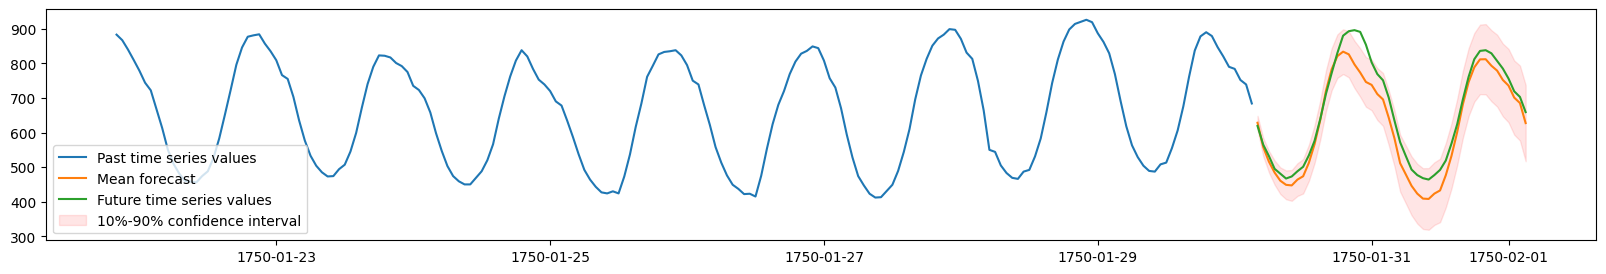

In [15]:
import matplotlib.pyplot as plt

# TimeSeriesDataFrame can also be loaded directly from a file
test_data = TimeSeriesDataFrame.from_path("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/test.csv")

plt.figure(figsize=(20, 3))

item_id = "H1"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][-48:]

plt.plot(y_past[-200:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend();

In [12]:
# The test score is computed using the last
# prediction_length=48 timesteps of each time series in test_data
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.855041,-0.914341,130.159747,130.339992,2.924985,8
1,RecursiveTabular,-0.862797,-0.933874,2.895851,3.843854,18.796232,5
2,SeasonalNaive,-1.022854,-1.216909,3.498383,0.231307,0.116866,2
3,DirectTabular,-1.683834,-1.370318,0.575695,0.613202,8.278683,6
4,ETS,-1.805637,-1.968375,123.174825,125.651629,0.111912,3
5,Theta,-1.905365,-2.142531,26.133566,31.198688,0.114476,4
6,TemporalFusionTransformer,-2.145473,-2.479289,0.654124,0.542875,458.901774,7
7,Naive,-6.696079,-6.662942,0.313584,3.701273,0.117944,1


In [13]:
# Another AutoGluon example
df = pd.read_csv("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_daily_subset/train.csv")
df.head()

,item_id,timestamp,target
0,D1737,1995-05-23,1900.0
1,D1737,1995-05-24,1877.0
2,D1737,1995-05-25,1873.0
3,D1737,1995-05-26,1859.0
4,D1737,1995-05-27,1876.0


In [14]:
static_features_df = pd.read_csv("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_daily_subset/metadata.csv")
static_features_df.head()

,item_id,domain
0,D1737,Industry
1,D1843,Industry
2,D2246,Finance
3,D909,Micro
4,D1345,Micro


In [15]:
train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="timestamp",
    static_features_df=static_features_df,
)
train_data.head()

target
item_id timestamp         
D1737   1995-05-23  1900.0
        1995-05-24  1877.0
        1995-05-25  1873.0
        1995-05-26  1859.0
        1995-05-27  1876.0

In [16]:
train_data.static_features.head()

,domain
item_id,
D1737,Industry
D1843,Industry
D2246,Finance
D909,Micro
D1345,Micro


In [17]:
train_data.static_features = static_features_df

In [18]:
predictor = TimeSeriesPredictor(prediction_length=14).fit(train_data)

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels\ag-20240130_145936'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.9.12
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          8
GPU Count:          0
Memory Avail:       5.08 GB / 15.78 GB (32.2%)
Disk Space Avail:   106.55 GB / 475.83 GB (22.4%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 14,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'D'
Provided train_data has 244460 rows, 100 time series. Median time series length is 3193 (min=115, max=4315). 

Provided dataset contains following columns:
	target:         

KeyboardInterrupt: 

In [ ]:
import numpy as np
train_data ["log_target"] = np.log(train_data["target"])

WEEKEND_INDICES = [5, 6]
timestamps = train_data.index.get_level_values("timestamp")
train_data["weekend"] = timestamps.weekday.isin(WEEKEND_INDICES).astype(float)

train_data.head()

target  log_target  weekend
item_id timestamp                              
D1737   1995-05-23  1900.0    7.549609      0.0
        1995-05-24  1877.0    7.537430      0.0
        1995-05-25  1873.0    7.535297      0.0
        1995-05-26  1859.0    7.527794      0.0
        1995-05-27  1876.0    7.536897      1.0

In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length=14,
    target="target",
    known_covariates_names=["weekend"],
).fit(train_data)

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels\ag-20240122_103813'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.9.12
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          8
GPU Count:          0
Memory Avail:       5.04 GB / 15.78 GB (31.9%)
Disk Space Avail:   98.59 GB / 475.83 GB (20.7%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': 'default',
 'known_covariates_names': ['weekend'],
 'num_val_windows': 1,
 'prediction_length': 14,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'D'
Provided train_data has 244460 rows, 100 time series. Median time series length is 3193 (min=115, max=4315). 

Provided dataset contains following columns:
	target: 

In [ ]:
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe

future_index = get_forecast_horizon_index_ts_dataframe(train_data, prediction_length=14)
future_timestamps = future_index.get_level_values("timestamp")
known_covariates = pd.DataFrame(index=future_index)
known_covariates["weekend"] = future_timestamps.weekday.isin(WEEKEND_INDICES).astype(float)

known_covariates.head()

weekend
item_id timestamp          
D1737   1997-05-28      0.0
        1997-05-29      0.0
        1997-05-30      0.0
        1997-05-31      1.0
        1997-06-01      1.0

In [ ]:
# Truncate the output of visual studio
pd.options.display.max_rows = 10
predictor.predict(train_data, known_covariates=known_covariates)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean          0.1          0.2          0.3  \
item_id timestamp                                                         
D1737   1997-05-28   1572.382802  1513.698481  1534.017049  1548.954057   
        1997-05-29   1572.710248  1493.447912  1520.747069  1540.335890   
        1997-05-30   1566.403188  1470.593541  1503.560337  1526.921390   
        1997-05-31   1565.915053  1457.552920  1493.951961  1521.255311   
        1997-06-01   1573.220234  1453.502400  1493.904195  1523.902510   
...                          ...          ...          ...          ...   
D2345   2013-07-18  10237.319433  9657.754649  9859.129548  9999.965112   
        2013-07-19  10230.135186  9618.135947  9831.504888  9980.911645   
        2013-07-20  10226.515181  9593.101578  9803.362813  9970.523507   
        2013-07-21  10206.160739  9552.970590  9776.016180  9931.647357   
        2013-07-22  10210.852844  9523.904990  9745.879899  9921.000057   

                             0.4           0.5           0.6           0.7  \
item_id timestamp                                                            
D1737   1997-05-28   1561.376856   1572.714774   1584.901632   1597.868980   
        1997-05-29   1557.024610   1572.037834   1588.331449   1604.669251   
        1997-05-30   1547.094213   1565.692844   1585.462745   1604.271726   
        1997-05-31   1542.641272   1563.031456   1585.695150   1607.737551   
        1997-06-01   1548.505119   1571.586073   1596.150520   1620.024233   
...                          ...           ...           ...           ...   
D2345   2013-07-18  10133.286972  10238.756697  10349.550811  10453.927259   
        2013-07-19  10109.397084  10233.461431  10354.825837  10468.750554   
        2013-07-20  10098.402993  10214.319525  10342.775039  10480.553203   
        2013-07-21  10080.097587  10193.424834  10317.276713  10462.977332   
        2013-07-22  10080.884535  10206.937102  10329.934635  10454.759894   

                             0.8           0.9  
item_id timestamp                               
D1737   1997-05-28   1611.412992   1632.804831  
        1997-05-29   1624.022335   1651.787835  
        1997-05-30   1627.901841   1660.928915  
        1997-05-31   1634.325995   1670.129573  
        1997-06-01   1649.633772   1691.596335  
...                          ...           ...  
D2345   2013-07-18  10591.341643  10804.278339  
        2013-07-19  10608.368913  10809.138840  
        2013-07-20  10633.663183  10834.070115  
        2013-07-21  10626.801725  10854.633028  
        2013-07-22  10640.161920  10861.868983  

[1400 rows x 10 columns]

In [ ]:
import holidays

timestamps = train_data.index.get_level_values("timestamp")
country_holidays = holidays.country_holidays(
    country="US",  # make sure to select the correct country/region!
    # Add + 1 year to make sure that holidays are initialized for the forecast horizon
    years=range(timestamps.min().year, timestamps.max().year + 1),
)
# Convert dict to pd.Series for pretty visualization
pd.Series(country_holidays).sort_index().head()

1978-01-01               New Year's Day
1978-01-02    New Year's Day (observed)
1978-02-20        Washington's Birthday
1978-05-29                 Memorial Day
1978-07-04             Independence Day
dtype: object

In [ ]:
import datetime

# must cover the full train time range + forecast horizon
custom_holidays = {
    datetime.date(1995, 1, 29): "Superbowl",
    datetime.date(1995, 11, 29): "Black Friday",
    datetime.date(1996, 1, 28): "Superbowl",
    datetime.date(1996, 11, 29): "Black Friday",
    # ... 
}

In [ ]:
def add_holiday_features(
    ts_df: TimeSeriesDataFrame, 
    country_holidays: dict,
    include_individual_holidays: bool = True,
    include_holiday_indicator: bool = True,
) -> TimeSeriesDataFrame:
    """Add holiday indicator columns to a TimeSeriesDataFrame."""
    ts_df = ts_df.copy()
    timestamps = ts_df.index.get_level_values("timestamp")
    country_holidays_df = pd.get_dummies(pd.Series(country_holidays)).astype(float)
    holidays_df = country_holidays_df.reindex(timestamps.date).fillna(0)
    if include_individual_holidays:
        ts_df[holidays_df.columns] = holidays_df.values
    if include_holiday_indicator:
        ts_df["Holiday"] = holidays_df.max(axis=1).values
    return ts_df

In [ ]:
add_holiday_features(train_data, country_holidays, include_individual_holidays=False).head()

target  log_target  weekend  Holiday
item_id timestamp                                       
D1737   1995-05-23  1900.0    7.549609      0.0      0.0
        1995-05-24  1877.0    7.537430      0.0      0.0
        1995-05-25  1873.0    7.535297      0.0      0.0
        1995-05-26  1859.0    7.527794      0.0      0.0
        1995-05-27  1876.0    7.536897      1.0      0.0

In [ ]:
train_data_with_holidays = add_holiday_features(train_data, country_holidays)
train_data_with_holidays.head()

target  log_target  weekend  Christmas Day  \
item_id timestamp                                                
D1737   1995-05-23  1900.0    7.549609      0.0            0.0   
        1995-05-24  1877.0    7.537430      0.0            0.0   
        1995-05-25  1873.0    7.535297      0.0            0.0   
        1995-05-26  1859.0    7.527794      0.0            0.0   
        1995-05-27  1876.0    7.536897      1.0            0.0   

                    Christmas Day (observed)  Columbus Day  Independence Day  \
item_id timestamp                                                              
D1737   1995-05-23                       0.0           0.0               0.0   
        1995-05-24                       0.0           0.0               0.0   
        1995-05-25                       0.0           0.0               0.0   
        1995-05-26                       0.0           0.0               0.0   
        1995-05-27                       0.0           0.0               0.0   

                    Independence Day (observed)  \
item_id timestamp                                 
D1737   1995-05-23                          0.0   
        1995-05-24                          0.0   
        1995-05-25                          0.0   
        1995-05-26                          0.0   
        1995-05-27                          0.0   

                    Juneteenth National Independence Day  \
item_id timestamp                                          
D1737   1995-05-23                                   0.0   
        1995-05-24                                   0.0   
        1995-05-25                                   0.0   
        1995-05-26                                   0.0   
        1995-05-27                                   0.0   

                    Juneteenth National Independence Day (observed)  \
item_id timestamp                                                     
D1737   1995-05-23                                              0.0   
        1995-05-24                                              0.0   
        1995-05-25                                              0.0   
        1995-05-26                                              0.0   
        1995-05-27                                              0.0   

                    Labor Day  Martin Luther King Jr. Day  Memorial Day  \
item_id timestamp                                                         
D1737   1995-05-23        0.0                         0.0           0.0   
        1995-05-24        0.0                         0.0           0.0   
        1995-05-25        0.0                         0.0           0.0   
        1995-05-26        0.0                         0.0           0.0   
        1995-05-27        0.0                         0.0           0.0   

                    New Year's Day  New Year's Day (observed)  Thanksgiving  \
item_id timestamp                                                             
D1737   1995-05-23             0.0                        0.0           0.0   
        1995-05-24             0.0                        0.0           0.0   
        1995-05-25             0.0                        0.0           0.0   
        1995-05-26             0.0                        0.0           0.0   
        1995-05-27             0.0                        0.0           0.0   

                    Veterans Day  Veterans Day (observed)  \
item_id timestamp                                           
D1737   1995-05-23           0.0                      0.0   
        1995-05-24           0.0                      0.0   
        1995-05-25           0.0                      0.0   
        1995-05-26           0.0                      0.0   
        1995-05-27           0.0                      0.0   

                    Washington's Birthday  Holiday  
item_id timestamp                                   
D1737   1995-05-23                    0.0      0.0  
        1995-05-24                    0.0      0.0  

In [ ]:
future_index = get_forecast_horizon_index_ts_dataframe(train_data, prediction_length=14)
future_timestamps = future_index.get_level_values("timestamp")
known_covariates = add_holiday_features(pd.DataFrame(index=future_index), country_holidays)
known_covariates.head()

Christmas Day  Christmas Day (observed)  Columbus Day  \
item_id timestamp                                                           
D1737   1997-05-28            0.0                       0.0           0.0   
        1997-05-29            0.0                       0.0           0.0   
        1997-05-30            0.0                       0.0           0.0   
        1997-05-31            0.0                       0.0           0.0   
        1997-06-01            0.0                       0.0           0.0   

                    Independence Day  Independence Day (observed)  \
item_id timestamp                                                   
D1737   1997-05-28               0.0                          0.0   
        1997-05-29               0.0                          0.0   
        1997-05-30               0.0                          0.0   
        1997-05-31               0.0                          0.0   
        1997-06-01               0.0                          0.0   

                    Juneteenth National Independence Day  \
item_id timestamp                                          
D1737   1997-05-28                                   0.0   
        1997-05-29                                   0.0   
        1997-05-30                                   0.0   
        1997-05-31                                   0.0   
        1997-06-01                                   0.0   

                    Juneteenth National Independence Day (observed)  \
item_id timestamp                                                     
D1737   1997-05-28                                              0.0   
        1997-05-29                                              0.0   
        1997-05-30                                              0.0   
        1997-05-31                                              0.0   
        1997-06-01                                              0.0   

                    Labor Day  Martin Luther King Jr. Day  Memorial Day  \
item_id timestamp                                                         
D1737   1997-05-28        0.0                         0.0           0.0   
        1997-05-29        0.0                         0.0           0.0   
        1997-05-30        0.0                         0.0           0.0   
        1997-05-31        0.0                         0.0           0.0   
        1997-06-01        0.0                         0.0           0.0   

                    New Year's Day  New Year's Day (observed)  Thanksgiving  \
item_id timestamp                                                             
D1737   1997-05-28             0.0                        0.0           0.0   
        1997-05-29             0.0                        0.0           0.0   
        1997-05-30             0.0                        0.0           0.0   
        1997-05-31             0.0                        0.0           0.0   
        1997-06-01             0.0                        0.0           0.0   

                    Veterans Day  Veterans Day (observed)  \
item_id timestamp                                           
D1737   1997-05-28           0.0                      0.0   
        1997-05-29           0.0                      0.0   
        1997-05-30           0.0                      0.0   
        1997-05-31           0.0                      0.0   
        1997-06-01           0.0                      0.0   

                    Washington's Birthday  Holiday  
item_id timestamp                                   
D1737   1997-05-28                    0.0      0.0  
        1997-05-29                    0.0      0.0  
        1997-05-30                    0.0      0.0  
        1997-05-31                    0.0      0.0  
        1997-06-01                    0.0      0.0

In [ ]:
# add column weekend to known_covariates
known_covariates["weekend"] = future_timestamps.weekday.isin(WEEKEND_INDICES).astype(float)


predictions = predictor.predict(train_data_with_holidays, known_covariates=known_covariates)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [ ]:
# Show me column name of known_covariates
known_covariates.columns


Index(['Christmas Day', 'Christmas Day (observed)', 'Columbus Day',
       'Independence Day', 'Independence Day (observed)',
       'Juneteenth National Independence Day',
       'Juneteenth National Independence Day (observed)', 'Labor Day',
       'Martin Luther King Jr. Day', 'Memorial Day', 'New Year's Day',
       'New Year's Day (observed)', 'Thanksgiving', 'Veterans Day',
       'Veterans Day (observed)', 'Washington's Birthday', 'Holiday',
       'weekend'],
      dtype='object')

In [ ]:
prediction_length = 48
data = TimeSeriesDataFrame.from_path("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/train.csv")
train_data, test_data = data.train_test_split(prediction_length)

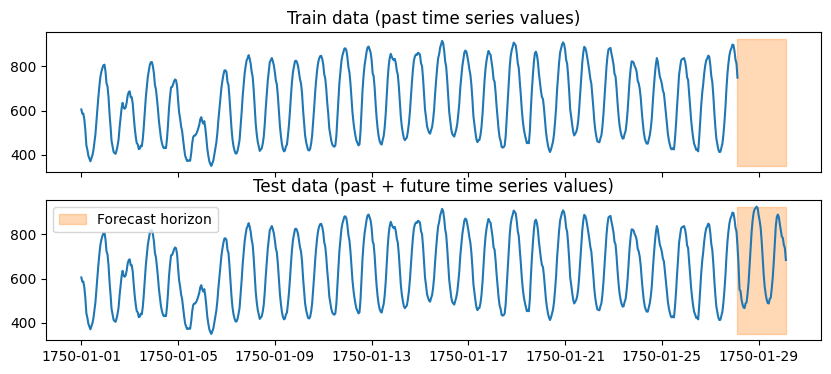

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

item_id = "H1"
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=[10, 4], sharex=True)
train_ts = train_data.loc[item_id]
test_ts = test_data.loc[item_id]
ax1.set_title("Train data (past time series values)")
ax1.plot(train_ts)
ax2.set_title("Test data (past + future time series values)")
ax2.plot(test_ts)
for ax in (ax1, ax2):
    ax.fill_between(np.array([train_ts.index[-1], test_ts.index[-1]]), test_ts.min(), test_ts.max(), color="C1", alpha=0.3, label="Forecast horizon")
plt.legend()
plt.show()